# Proteomics CSF Analysis of PPMI 
In this project we analyse **Cerebrospinal Fluid (CSF) proteomic** data of Parkinson's disease patients.
- CSF is a clear fluid that surrounds the brain and spinal cord. It provides a protective cushion for the brain and helps remove waste products.
- The collected CSF can be analyzed to look for various markers, proteins, or other substances that may be indicative of neurological conditions, including Parkinson's disease.

This study aimed to find specific protein patterns in the cerebrospinal fluid (CSF) that are linked to Parkinson's disease (PD).

# XGboost ML from proteomic gene expressions among PD and Control patients.

In [46]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

In [8]:
# The pathes (Directories) to the data
path = Path("/home/znazari/data/open_proteomic/")
path2 = Path("/home/znazari/data/")

In [67]:
final_proteomic_patients=pd.read_csv(path/"final_proteomic_patients.csv")

# Excluding from the data the patients whom they are using dopaminergic drugs or have particular mutation in their genes

In [26]:
patients_drugs1 = pd.read_csv(path2/"patients_using_ddrug.csv")
patients_drugs = patients_drugs1["PATNO"].astype(str)

mutation_patients = pd.read_csv(path2/"mutated_g_patients.csv")
new_mutation=mutation_patients['PATNO'].astype(str)

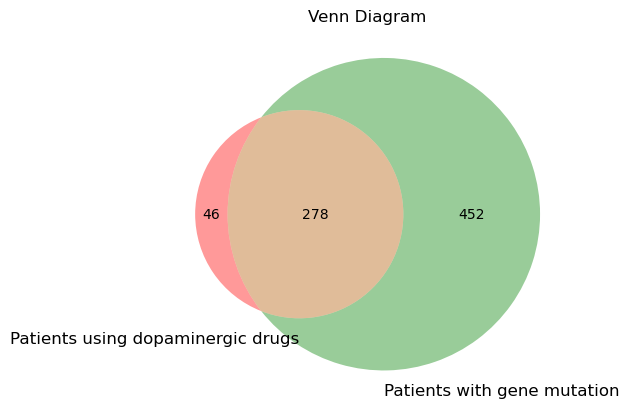

In [68]:
# Create Series
series1 = pd.Series(patients_drugs)
series2 = pd.Series(new_mutation)

# Find union, difference, and intersection directly based on their values
union_values = set(series1.values) | set(series2.values)
difference_values = set(series2.values)-set(series1.values) 
intersection_values = set(series1.values) & set(series2.values)

# Create a Venn diagram
venn2(subsets=(len(series1) - len(intersection_values), len(series2) - len(intersection_values), 
               len(intersection_values)),
      set_labels=('Patients using dopaminergic drugs', 'Patients with gene mutation'))

# Display the plot
plt.title('Venn Diagram')
plt.show()


In [69]:
# Create Series
series1 = pd.Series(patients_drugs)
series2 = pd.Series(new_mutation)

# Find union, difference, and intersection directly based on their values
union_values = pd.Series(list(set(series1.values) | set(series2.values)))

In [ ]:

result_pivot_filtered = result_pivot.drop(columns=new_mutation, errors='ignore')

patient_diagnosis_df = result_df[['PATNO', 'COHORT']].drop_duplicates()


new_patients_diagnos = new_diagnosis[~new_diagnosis['PATNO'].isin(mutation_patients['PATNO'].astype(str))]


new_patients_diagnos = new_patients_diagnos.reset_index(drop=True)

transposed_main=result_pivot_filtered.T
transposed_main = transposed_main.reset_index().rename(columns={'index': 'PATNO'})

#  Merge the two DataFrames on 'PATNO'
merged_df = pd.merge(transposed_main, new_patients_diagnos, on='PATNO')

In [ ]:
# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#  Initialize and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

#  Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')

In [ ]:
# Merge the two DataFrames on 'PATNO'
merged_df = pd.merge(transposed_main, new_patients_diagnos, on='PATNO')

# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']

# Convert diagnosis labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

#  Initialize and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

#  Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')

In [ ]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Separate features (X) and target variable (y)
X = merged_df.drop(['PATNO', 'COHORT'], axis=1)
y = merged_df['COHORT']


# Initialize StratifiedKFold for cross-validation
n_splits = 10  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an array to store AU-ROC scores
au_roc_scores = []

# Perform cross-validation and repeat XGBoost algorithm
for _ in range(5):  # Repeat 5 times
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize and train the XGBoost model
        xgb_model = XGBClassifier()
        xgb_model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        # Calculate AU-ROC score
        au_roc_score = roc_auc_score(y_test, y_pred_proba)

        # Append the AU-ROC score to the array
        au_roc_scores.append(au_roc_score)

# Calculate the average AU-ROC score over all repetitions and folds
average_au_roc_score = sum(au_roc_scores) / len(au_roc_scores)

# Print the average AU-ROC score
print(f'Average AU-ROC Score: {average_au_roc_score}')
